In [86]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from sklearn import metrics
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from opencage.geocoder import OpenCageGeocode
import time

In [87]:
# Reading secret JSON with api_keys
import json

with open ('data/secret.json', 'r') as f:
    secret = json.load(f)

In [88]:
# Select random state for project
random_state = 42

In [89]:
# Reading csv income data as dataframe and show head 5 
hotels_df = pd.read_csv('data/hotels.csv')
hotels_df.head()

hotel_address   
0  Stratton Street Mayfair Westminster Borough Lo...  \
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score   
0                           581   2/19/2016            8.4  \
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality   
0                         The May Fair Hotel      United Kingdom   \
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts   
0             Leaving                                   3  \
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review   
0                     1994                                 Staff were amazing  \
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts   
0                                  4  \
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score   
0                                           7            10.0  \
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review   
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day  \
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643  
3  48.888697  2.394540  
4  52.385601  4.847060

In [90]:
# Checking data frame size and information about type of data
print(f'Data frame size: {hotels_df.shape}')
print()
display(hotels_df.info())

Data frame size: (386803, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                        

None

hotel_address, review_date, hotel_name, reviewer_nationality, negative_review, positive_review, tags, days_since_review have the object type

lat and lng features have nan's

Let's check them.

In [91]:
# Finding hotel unique numbers
print(f"Number of unique hotle names: {hotels_df['hotel_name'].nunique()}")

Number of unique hotle names: 1492


The hotel_name feature has a large number of unique values. As I think (and checked in previous versions of the code) this feature is not so important for the model. In previson version try 

But i will not remove it yet

In the previous version, I tried to encode it with a BinaryEncoder and it had no significance

In [92]:
# Checking review_date format
display(hotels_df['review_date'].head(2))

0    2/19/2016
1    1/12/2017
Name: review_date, dtype: object

In [93]:
# Converting review date column to datetime format
hotels_df['review_date'] = pd.to_datetime(hotels_df['review_date'], format='%m/%d/%Y')
# Checking date interval
print(f'Last review was: {hotels_df["review_date"].max().date()}')
print(f'First review was: {hotels_df["review_date"].min().date()}')

Last review was: 2017-08-03
First review was: 2015-08-04


This review is for 3 years only. The sign of the year is not informative. From date to create new features I use week number and day number.

In [94]:
# Creating date_week and date_day columns from the review_date
hotels_df['date_week'] = hotels_df['review_date'].apply(lambda x: x.isocalendar()[1])
hotels_df['date_day'] = hotels_df['review_date'].apply(lambda x: x.isocalendar()[2])

I will also create a features of the season

In [95]:
# Creating season features from review_date
hotels_df['date_winter'] = hotels_df['review_date'].apply(lambda x: True if (x.month==12) or (1<=x.month<=2) else False)
hotels_df['date_spring'] = hotels_df['review_date'].apply(lambda x: True if 3<=x.month<=5 else False)
hotels_df['date_summer'] = hotels_df['review_date'].apply(lambda x: True if 6<=x.month<=8 else False)
hotels_df['date_autumn'] = hotels_df['review_date'].apply(lambda x: True if 9<=x.month<=11 else False)

After creating new features, I can remove the validation date column.

In [96]:
# Deleting review_date column
hotels_df = hotels_df.drop(columns=['review_date'])

In [97]:
# Checking days_since_review content
display(hotels_df['days_since_review'].head(2))

0    531 day
1    203 day
Name: days_since_review, dtype: object

In [98]:
# Converting to integer days_since_review column
hotels_df['days_since_review'] = hotels_df['days_since_review'].apply(lambda x: int(x.split(sep=' ')[0]))

In [99]:
# # Converting hotel address to list type
# hotels_df['hotel_address'] = hotels_df['hotel_address'].apply(lambda x: x)
# Unique countries checking
hotels_df['hotel_address'].apply(lambda x: x.split(sep=' ')[-1]).unique()


array(['Kingdom', 'France', 'Netherlands', 'Italy', 'Austria', 'Spain'],
      dtype=object)

In [100]:
# Creating new feature country
hotels_df['country'] = hotels_df['hotel_address'].apply(lambda x: 'United Kingdom' if x.split(sep=' ')[-1] == 'Kingdom' else x.split(sep=' ')[-1])

In [101]:
# Checking unique cities in the data
hotels_df['hotel_address'].apply(lambda x: x.split(sep=' ')[-5] if x.split(sep=' ')[-1] == 'Kingdom' else x.split(sep=' ')[-2]).unique()

array(['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona'],
      dtype=object)

In [102]:
# Creating city column
hotels_df['city'] = hotels_df['hotel_address'].apply(lambda x: x.split(sep=' ')[-5] if x.split(sep=' ')[-1] == 'Kingdom' else x.split(sep=' ')[-2])

Each country has one city in the data. I will choose the country attribute for further use and immediately encode it using OneHotEcncoding. I will need a sign of the city in the future.

In [103]:
hotels_df['reviewer_nationality'] = hotels_df['reviewer_nationality'].apply(lambda x: x.strip())
hotels_df['country'] = hotels_df['country'].apply(lambda x: x.strip())

# Creating column inner traveller
hotels_df['inner_traveller'] = (hotels_df['reviewer_nationality'] == hotels_df['country'])

In [104]:
# Encoding country by getdummies(OneHotEncoder)
hotels_df = pd.get_dummies(hotels_df, columns=['country'])

In [105]:
# Check NaN's in lat and lng columns
# Finding nulls numbers in lat and lng columns
print(f"lat column have {round(hotels_df['lat'].isnull().sum() / hotels_df.shape[0] * 100, 2)}% nulls")
print(f"lng column have {round(hotels_df['lng'].isnull().sum() / hotels_df.shape[0] * 100, 2)}% nulls")

lat column have 0.63% nulls
lng column have 0.63% nulls


In fact, the simplest option would be to remove missing values due to their small number. But according to the conditions, this cannot be done, so I will use the OpenCageGeocode library to get data from the address.

In [106]:
#Fill nans in lan and lng columns
key = secret['API_KEY_OPENCAGE']
geocoder = OpenCageGeocode(key)
# Get latitude and longtitude from OpenCageGeocode api
for address in hotels_df[hotels_df['lat'].isnull()]['hotel_address'].unique():
    query = address
    results = geocoder.geocode(query)
    # print(results[0]['geometry']['lat'])
    # print(results[0]['geometry']['lng'])
    lat = float(results[0]['geometry']['lat'])
    lng = float(results[0]['geometry']['lng'])
    hotels_df.loc[hotels_df['hotel_address'] == address, 'lat'] = lat
    hotels_df.loc[hotels_df['hotel_address'] == address, 'lng'] = lng
    # 1 second pause becouse api accept 1 request per second at free subscription
    time.sleep(1)

In [107]:
hotels_df['city'].unique()

array(['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona'],
      dtype=object)

In [108]:
# Changing city column to coordintes of centre
def city_coordinates(city):
    """This function recieve city name and return cordinates of city center

    Args:
        city (string): city name

    Returns:
        tuple: coordinates of city center
    """
    # Cordinates of cities center from internet
    london = (51.504331316, -0.123166174)
    paris = (48.85889, 2.32004)
    amsterdam = (52.37308, 4.89245)
    milan = (45.46419, 9.18963)
    vienna = (48.20835, 16.37250)
    barcelona = (41.38289, 2.17743)
    if city == 'London':
        return london
    if city == 'Paris':
        return paris
    if city == 'Amsterdam':
        return amsterdam
    if city == 'Milan':
        return milan
    if city == 'Vienna':
        return vienna
    if city == 'Barcelona':
        return barcelona
    

hotels_df['city_coord'] = hotels_df['city'].apply(city_coordinates)

Now i can calculate distance to city centre

In [109]:
# Creating coordinates column
hotels_df['coordinates'] = hotels_df.apply(lambda x: (x['lat'], x['lng']), axis=1)

#Importing vincenty for calculating distance to centre
from vincenty import vincenty


def get_center_distance(row):
    """Function for calculating distance to city centre

    Args:
        row (pd.Series): row from Dataframe with hotel information

    Returns:
        float: distance to city centre
    """
    
    coord1 = row['city_coord']
    coord2 = row['coordinates']
    distance = vincenty(coord1, coord2, miles=False)
    return distance

# Function applying
hotels_df['distance_to_center'] = hotels_df.apply(get_center_distance, axis=1)

In [110]:
hotels_df[hotels_df['distance_to_center'] > 20]['hotel_name'].unique()

array(['Maison Albar Hotel Paris Op ra Diamond',
       'Mercure Paris Gare Montparnasse'], dtype=object)

After checking the distance data, I found two errors. This is OpenGeocode data errors. 
I wiil find true cordinates in internet.

In [111]:
address_errors = hotels_df[hotels_df['distance_to_center'] > 20]['hotel_address'].unique()


In [112]:
# Chaging coordinates from geocode error to coordinates from internet
hotels_df.loc[hotels_df['hotel_address'] == address_errors[0], 'coordinates'] = hotels_df[hotels_df['hotel_address'] == address_errors[0]]['coordinates'].apply(lambda x:(48.87651643665948, 2.3226524122492713))
hotels_df.loc[hotels_df['hotel_address'] == address_errors[1], 'coordinates'] = hotels_df[hotels_df['hotel_address'] == address_errors[1]]['coordinates'].apply(lambda x:(48.840769059266734, 2.3248300237973663))
# Calculating new distance
hotels_df.loc[hotels_df['hotel_address'] == address_errors[0], 'distance_to_center'] = hotels_df[hotels_df['hotel_address'] == address_errors[0]].apply(get_center_distance, axis=1)
hotels_df.loc[hotels_df['hotel_address'] == address_errors[1], 'distance_to_center'] = hotels_df[hotels_df['hotel_address'] == address_errors[1]].apply(get_center_distance, axis=1)
# Checking again
hotels_df[hotels_df['distance_to_center'] > 20]['hotel_name'].unique()

array([], dtype=object)

In [113]:
def get_post_codes(address):
    """Thtis fuction recieve hotel_address string and return post code

    Args:
        address (string): hotrl_address

    Returns:
        string: post code
    """
    if address.split(sep= ' ')[-1] == 'Kingdom' or address.split(sep=' ')[-1] == 'Netherlands':
        return address.split(sep=' ')[-4]
    else:
        return address.split(sep=' ')[-3]
    
# Function aplying
hotels_df['postal_code'] = hotels_df['hotel_address'].apply(get_post_codes)

In [114]:
# District categories from Chat GPT 4
tourist_zip_list = ['W1J', 'WC1B', 'SE1', 'WC2B', 'WC2N', 'SW1A', 'SW1E', 'SW1H', 'SW1W', 
'SW1Y', 'SW1V', 'SW1X', 'E20', 'W11', 'W8', 'NW1', 'W1D', 'W1B', 'W1K', 'W2', 'W1T', 'SW19', 
'SW1P', '75006', '75008', '75001', '75007', '75005', '75004', '75116', '1012', '1017', '1011', 
'1016', '1015', '1013', '1018', '1019', '1014', '20121', '20123', '20122', '20129', '20145', 
'20125', '20136', '20144', '20135', '20126', '20138', '1010', '1015', '1020', '1030', '1040', 
'1050', '1060', '1070', '1080', '1090', '08001', '08002', '08003', '08004', '08007', '08008', 
'08010', '08011', '08012', '08013', '08005']

business_zip_list = ['EC3A', 'EC2M', 'EC2A', 'EC2R', 'EC3N', 'EC3V', 'EC4M', 'EC4V', 'EC4Y', 
'E14', 'WC2R', 'WC1V', 'WC1X', 'W1T', 'E1', 'E14', 'SW1W', 'SW1V', 'SW1X', 'EC1Y', 'EC1V', 
'W1H', 'W1U', 'EC2A', 'EC1R', 'EC1M', 'EC1Y', 'EC1V', 'EC3V', 'EC4A', '75009', '75002', 
'75015', '75013', '75014', '75016', '75012', '75017', '75018', '1043', '1077', '1062', '1064', 
'1066', '1067', '1058', '1054', '1053', '1052', '1072', '1071', '1075', '20124', '20154', 
'20159', '20148', '20157', '20152', '20139', '20149', '20153', '20142', '20155', '20146', 
'20158', '20156', '20133', '20132', '1010', '1015', '1020', '1030', '1040', '1050', '1100', 
'1110', '1120', '08018', '08019', '08010', '08011', '08014', '08015', '08009', '08040', 
'08036', '08037', '08039', '08013']

residence_zip_list = ['W5', 'W6', 'NW2', 'NW6', 'SW6', 'W8', 'W11', 'SW5', 'W2', 'NW1', 
'W13', 'W1H', 'E2', 'HA9', 'SW10', 'SE10', 'E1', 'E16', 'SW19', 'E1W', 'IG8', 'N4', 'W3', 
'E15', 'N1', 'NW8', 'NW3', 'N1C', 'NW4', 'SE11', 'SE16', 'SW5', 'SW7', 'W12', 'W14', 'W4', 
'W9', 'W10', 'SW8', 'SW11', 'SW15', 'SW3', 'W1W', 'W1G', 'W1C', 'W1F', 'W1U', 'WC1N', 'WC1H', 
'WC1E', 'NW3', 'W1S', 'SW14', '75010', '75011', '75012', '75013', '75014', '75015', '75017', 
'75019', '75020', '92170', '92120', '1091', '1092', '1093', '1096', '1097', '1082', '1083', 
'1087', '1031', '1033', '1055', '1057', '1019', '1018', '20161', '20143', '20142', '20136', 
'20144', '20155', '20127', '20135', '20146', '20162', '20156', '20126', '20128', '20133', 
'20132', '20131', '20141', '1060', '1070', '1080', '1090', '1100', '1110', '1120', '1130', 
'1140', '1150', '1160', '1170', '1210', '1220', '1230', '08023', '08026', '08028', '08025', 
'08029', '08034', '08035', '08036', '08037', '08038', '08039', '08040', '08022', '08021', 
'08017', '08006']

green_zip_list = ['W2', 'SW7', 'NW1', 'SW1V', 'SW1X', 'SW3', 'SW5', 'SW7', 'SW15', 'NW3', 
'NW8', 'W14', 'SW19', 'SE16', 'SW10', 'SE10', 'SE1', 'NW2', 'W9', 'SW11', '75016', '75015', 
'75019', '75012', '75116', '1071', '1072', '1075', '1077', '1057', '1067', '1105', '20138', 
'20145', '20157', '20152', '20143', '20149', '20144', '20146', '20158', '20156', '20162', 
'20141', '1130', '1140', '1150', '1160', '1170', '1190', '1210', '1220', '1230', '08023', 
'08026', '08028', '08025', '08034', '08035', '08038', '08022', '08021', '08017', '08006']

historical_zip_list = ['WC2B', 'WC2N', 'EC3N', 'EC4V', 'EC4Y', 'WC2R', 'WC1A', 'WC1H', 'WC1N', 
'WC1X', 'EC3A', 'EC3V', 'EC4M', 'EC1M', 'WC2A', 'EC4Y', 'EC3V', 'WC2E', 'WC1E', 'WC1B', 'W8', 
'W1K', 'EC3A', '75001', '75004', '75005', '75006', '75007', '75008', '75009', '1012', '1017', 
'1011', '1016', '1015', '1014', '1013', '20121', '20123', '20122', '20129', '20125', '20126', 
'20128', '20131', '20135', '20136', '1010', '1015', '1020', '1030', '1040', '1050', '1060', 
'1070', '1080', '1090', '08001', '08002', '08003', '08004', '08005', '08007', '08008', 
'08009', '08010', '08011', '08012', '08013', '08006']

shopping_zip_list = ['W1J', 'W1B', 'W1D', 'W1T', 'W1U', 'W1K', 'W1S', 'W1F', 'W1W', 'SW1Y', 
'SW3', 'SW5', 'SW7', 'W8', 'W11', 'W1C', 'W1G', 'W1K', 'W1S', 'W1W', 'W1F', 'W1C', 'WC1A', 
'SW1P', 'WC1B', 'SW1X', 'WC2A', 'W1H', 'W1U', '75008', '75009', '75001', '75002', '75006', 
'75007', '1012', '1017', '1011', '1052', '1054', '1053', '1058', '1016', '20121', '20123', 
'20122', '20129', '20154', '20159', '20148', '20125', '20153', '20155', '20127', '20135',
'1010', '1015', '1020', '1030', '1040', '1050', '1060', '1070', '08001', '08002', '08003', 
'08004', '08007', '08008', '08010', '08011', '08014', '08015', '08009', '08005', '08006']

entertaining_zip_list = ['W1D', 'WC2H', 'W1F', 'W1J', 'SW1Y', 'W1T', 'E20', 'WC1B', 'WC2B', 
'WC2N', 'WC2R', 'SW1A', 'SW1E', 'W1B', 'W1K', 'W1S', 'WC1E', 'WC2H', 'W2', 'SW1P', 'SW5', 
'WC1N', 'WC1V', 'SW1W', 'WC1X', 'WC2E', '75009', '75018', '75003', '75002', '75004', '75011', 
'75020', '1012', '1017', '1011', '1058', '1055', '1054', '1052', '20121', '20124', '20154', 
'20159', '20148', '20145', '20129', '20153', '20155', '20127', '20135', '20146', '20158', 
'1010', '1015', '1020', '1030', '1040', '1050', '1060', '1070', '1080', '1090', '1100', 
'08001', '08002', '08003', '08004', '08007', '08008', '08010', '08011', '08012', '08013', 
'08014', '08015', '08005', '08006']

transport_zip_list = ['E16', 'NW1', 'E1', 'WC1H', 'E14', 'W2', 'E15', 'E20', 'SE1', 'SW1V', 
'SW1W', 'SW1X', 'EC1Y', 'EC1V', 'W1H', 'W1U', 'W2', 'WC1V', 'WC2A', 'EC1R', 'E8', 'SE10', 
'E1W', 'WC1N', 'WC1A', 'EC2M', 'WC2B', 'W1D', 'WC1B', 'SW1W', 'SW10', 'WC1E', 'E2', 'NW2', 
'NW6', 'NW3', 'NW8', 'W5', 'W6', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'WC2E', 
'WC2R', 'W4', 'W1J', 'W1T', '75010', '75012', '75013', '75014', '75015', '75019', '75020', 
'92170', '92120', '1101', '1105', '1108', '1031', '1033', '1043', '1014', '1062', '1011',
'20138', '20124', '20154', '20159', '20157', '20152', '20161', '20153', '20142', '20133', 
'20132', '20131', '1100', '1110', '1120', '1010', '1015', '1020', '1030', '1040', '1050',
'08018', '08019', '08010', '08014', '08015', '08028', '08040', '08039', '08006']

suburb_zip_list = ['IG8', 'HA9', 'NW2', 'NW6', 'NW8', 'NW3', 'N1C', 'NW4', 'N4', 'N1', 'E2', 
'E8', 'E15', 'E1', 'E14', 'E20', 'E16', 'E1W', 'SE1', 'SE10', 'SE11', 'SE16', 'WC1H', 'W3', 
'SW6', 'SW7', 'SW8', 'SW10', 'SW11', 'SW15', 'SW19', 'W2', 'W12', '92170', '92120', '1064', 
'1066', '1067', '1031', '1033', '1101', '1105', '1108', '20162', '20156', '20126', '20128', 
'20133', '20132', '20131', '20141', '1190', '1210', '1220', '1230', '08950', '08034', 
'08035', '08038', '08022', '08021', '08017']

After 3 days of failing to get district names using reverse geocoding, I asked Сhat-GPT4 (3.5 model return a lot of mistakes) and will rely on its categorization of city districts for now) 

In [115]:
# Creating new columns with district category
hotels_df['tourist_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in tourist_zip_list else 0)
hotels_df['business_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in business_zip_list else 0)
hotels_df['residence_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in residence_zip_list else 0)
hotels_df['green_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in green_zip_list else 0)
hotels_df['historical_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in historical_zip_list else 0)
hotels_df['shopping_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in shopping_zip_list else 0)
hotels_df['entertaining_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in entertaining_zip_list else 0)
hotels_df['transport_hub_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in transport_zip_list else 0)
hotels_df['suburb_dist'] = hotels_df['postal_code'].apply(lambda x: 1 if x in suburb_zip_list else 0)

In [116]:
hotels_df.groupby(by=['city','tourist_dist'])['reviewer_score'].mean()

city       tourist_dist
Amsterdam  0               8.364241
           1               8.541199
Barcelona  0               8.307281
           1               8.706631
London     0               8.360582
           1               8.286079
Milan      0               8.314934
           1               8.403282
Paris      0               8.257817
           1               8.612245
Vienna     0               8.279897
           1               8.612666
Name: reviewer_score, dtype: float64

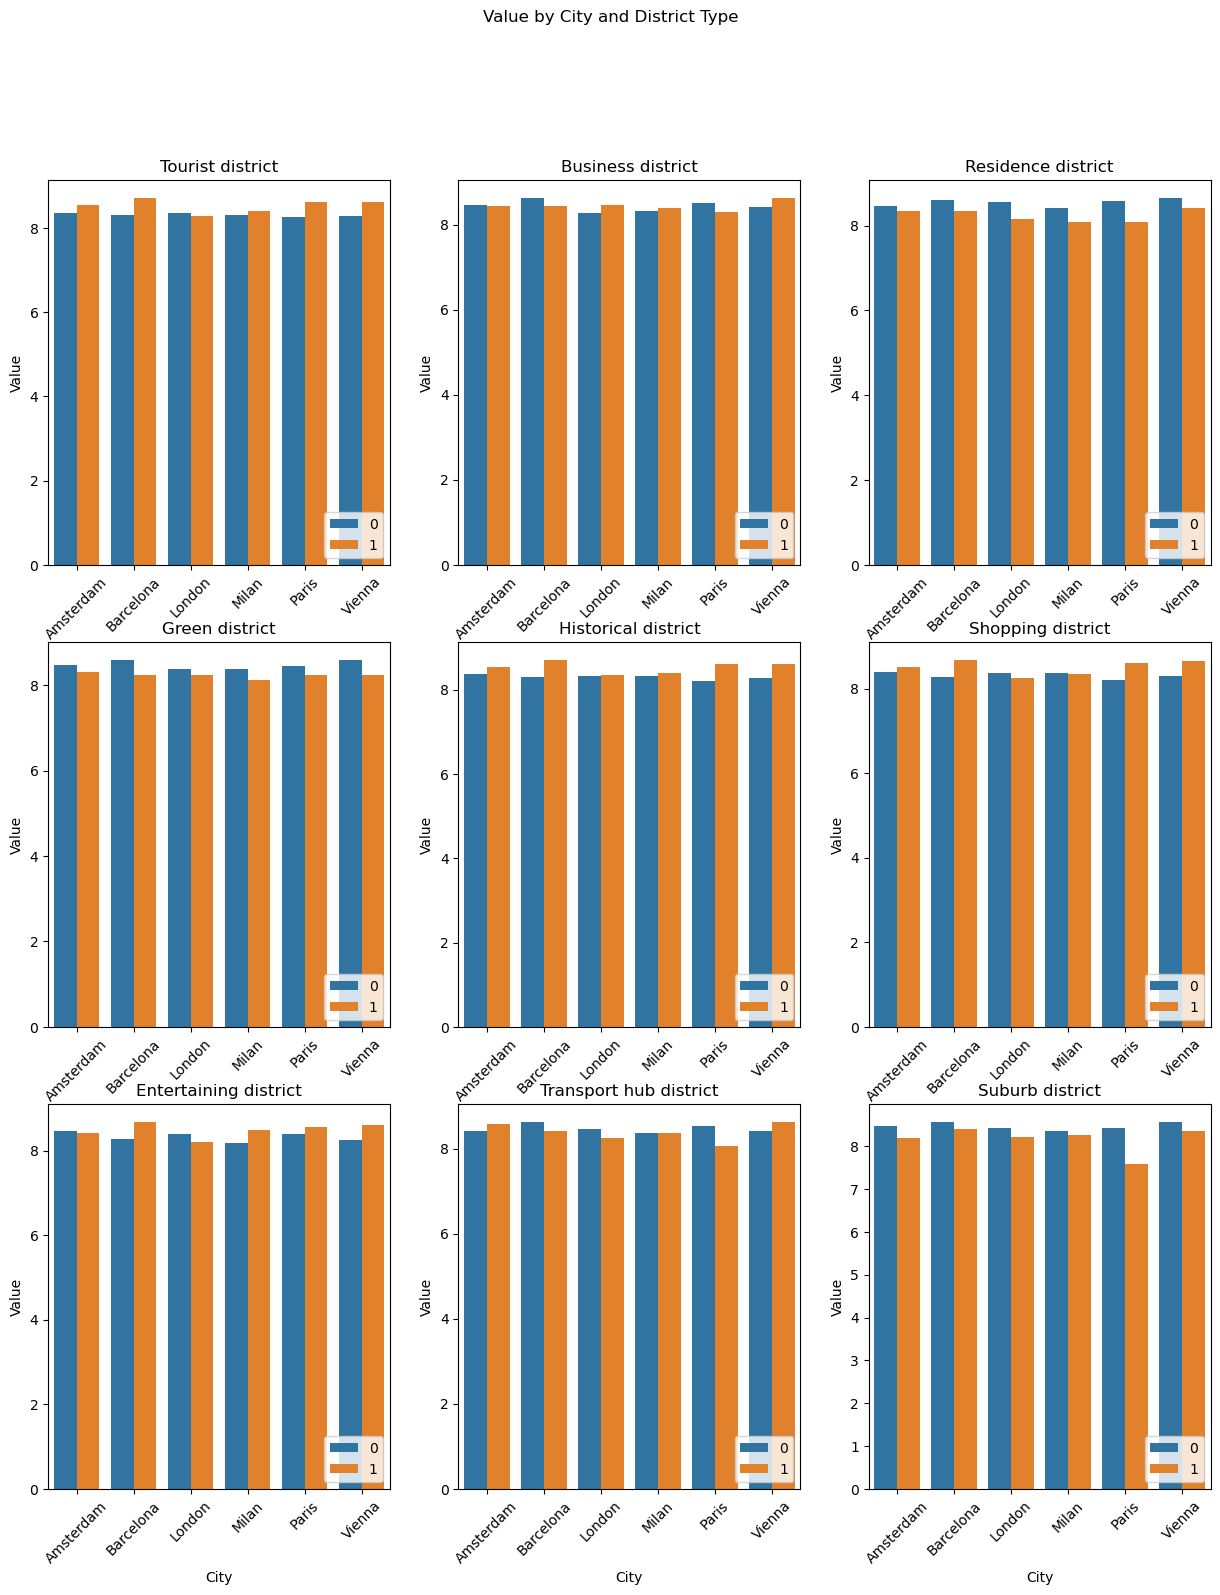

In [117]:
# Converting a dataframe from a multi-index format


# Creating barplot
fig = plt.figure(figsize=(15, 17))

ax = plt.subplot(3,3,1)
df_reset = hotels_df.groupby(by=['city','tourist_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Tourist District', 'Value']
sns.barplot(x='City', y='Value', hue='Tourist District', data=df_reset, ax=ax)
plt.title('Tourist district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,2)
df_reset = hotels_df.groupby(by=['city','business_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Business District', 'Value']
sns.barplot(x='City', y='Value', hue='Business District', data=df_reset, ax=ax)
plt.title('Business district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,3)
df_reset = hotels_df.groupby(by=['city','residence_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Residence District', 'Value']
sns.barplot(x='City', y='Value', hue='Residence District', data=df_reset, ax=ax)
plt.title('Residence district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,4)
df_reset = hotels_df.groupby(by=['city','green_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Green District', 'Value']
sns.barplot(x='City', y='Value', hue='Green District', data=df_reset, ax=ax)
plt.title('Green district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,5)
df_reset = hotels_df.groupby(by=['city','historical_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Historical District', 'Value']
sns.barplot(x='City', y='Value', hue='Historical District', data=df_reset, ax=ax)
plt.title('Historical district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,6)
df_reset = hotels_df.groupby(by=['city','shopping_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Shopping District', 'Value']
sns.barplot(x='City', y='Value', hue='Shopping District', data=df_reset, ax=ax)
plt.title('Shopping district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,7)
df_reset = hotels_df.groupby(by=['city','entertaining_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Entertaining District', 'Value']
sns.barplot(x='City', y='Value', hue='Entertaining District', data=df_reset, ax=ax)
plt.title('Entertaining district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,8)
df_reset = hotels_df.groupby(by=['city','transport_hub_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Transport hub District', 'Value']
sns.barplot(x='City', y='Value', hue='Transport hub District', data=df_reset, ax=ax)
plt.title('Transport hub district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax = plt.subplot(3,3,9)
df_reset = hotels_df.groupby(by=['city','suburb_dist'])['reviewer_score'].mean().reset_index()
df_reset.columns = ['City', 'Suburb District', 'Value']
sns.barplot(x='City', y='Value', hue='Suburb District', data=df_reset, ax=ax)
plt.title('Suburb district')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))

fig.suptitle('Value by City and District Type')
plt.show()

After plotting the dependence of the average score on the city and type of district, it can be concluded that the type of district does not affect the assessment very much. There are also reasons not to trust the classification into areas performed by ChatGPT.
For now, I'll leave this option.

In [118]:
# Reviews preparation
hotels_df['positive_review'] = hotels_df['positive_review'].apply(lambda x: x.lower())
hotels_df['negative_review'] = hotels_df['negative_review'].apply(lambda x: x.lower())
hotels_df['positive_review'] = hotels_df['positive_review'].apply(lambda x: x.strip())
hotels_df['negative_review'] = hotels_df['negative_review'].apply(lambda x: x.strip())
hotels_df['positive_list'] = hotels_df['positive_review'].apply(lambda x: x.split())
hotels_df['negative_list'] = hotels_df['negative_review'].apply(lambda x: x.split())
hotels_df['positive_review'] = hotels_df['positive_review'].str.replace('wi fi', 'wifi')
hotels_df['positive_review'] = hotels_df['positive_review'].str.replace('wi-fi', 'wifi')
hotels_df['negative_review'] = hotels_df['negative_review'].str.replace('wi fi', 'wifi')
hotels_df['negative_review'] = hotels_df['negative_review'].str.replace('wi-fi', 'wifi')


# Removing non alpha from reviews words list
def remove_non_alpha(words_list):
    """Function for cleaning revievs words list from nonalpha data

    Args:
        words_list (list): reviews words list

    Returns:
        list: reviews words list without nonalpha data
    """
    result = []
    for word in words_list:
        if word.isalpha():
            result.append(word)
    return result

# Applying function
hotels_df['positive_list'] = hotels_df['positive_list'].apply(remove_non_alpha)
hotels_df['negative_list'] = hotels_df['negative_list'].apply(remove_non_alpha)

# # Importing stopwords from NLTK library
# from nltk.corpus import stopwords
# import nltk

# nltk.download('stopwords')
# stop_words = stopwords.words('english')

# def remove_stop_words(worsds_list):
#     result = []
#     for word in worsds_list:
#         if word not in stop_words:
#             result.append(word)
#     return result

# hotels_df['positive_list'] = hotels_df['positive_list'].apply(remove_stop_words)
# hotels_df['negative_list'] = hotels_df['negative_list'].apply(remove_stop_words)

In [119]:
# # Import fasttext library
# import fasttext

# # Downloading pretrained model
# import urllib.request

# url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
# filename = "lid.176.bin"
# urllib.request.urlretrieve(url, filename)

# # Loading fasttext model
# model = fasttext.load_model('lid.176.bin')

# def detect_language(text):
#     predictions = model.predict(text, k=1)
#     lang = predictions[0][0].split('__')[-1]
#     return lang


# hotels_df['positive_lang_1'] = hotels_df['positive_review_1'].apply(detect_language)
# hotels_df['negative_lang_1'] = hotels_df['negative_review_1'].apply(detect_language)

In [120]:
# Reviews words list, back to string
hotels_df['positive_review_1'] = hotels_df['positive_list'].apply(lambda x: ' '.join(x))
hotels_df['negative_review_1'] = hotels_df['negative_list'].apply(lambda x: ' '.join(x))
# New total words count after cleaning
hotels_df['review_total_positive_word_counts'] = hotels_df['positive_list'].apply(lambda x: len(x))
hotels_df['review_total_negative_word_counts'] = hotels_df['negative_list'].apply(lambda x: len(x))

In [121]:
# Importing NLTK library
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk_sia = SentimentIntensityAnalyzer()


def nltk_analysis(df, col):
   
    df['polarity_scores'] = df[col].apply(nltk_sia.polarity_scores)
    
    if col == 'positive_review' or col == 'positive_review_1':
        prefix = 'p_'
    if col == 'negative_review' or col == 'negative_review_1':
        prefix = 'n_'
    
    df['nltk_'+prefix+'neg']      = df['polarity_scores'].apply(lambda x: x['neg'])
    df['nltk_'+prefix+'neu']      = df['polarity_scores'].apply(lambda x: x['neu'])
    df['nltk_'+prefix+'pos']      = df['polarity_scores'].apply(lambda x: x['pos'])
    df['nltk_'+prefix+'compound'] = df['polarity_scores'].apply(lambda x: x['compound'])

    df.drop('polarity_scores', axis=1, inplace=True)
    
    return df


hotels_df = nltk_analysis(hotels_df, 'positive_review_1')
hotels_df = nltk_analysis(hotels_df, 'negative_review_1')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/smoke/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [122]:
# Affin sentiment analysis 
from afinn import Afinn

afinn = Afinn()


def afinn_analysis(df, col):
    """This function recieve dataframe with hotels data 
    and return it with Affinn Sentiment analysis 

    Args:
        df (DataFrame): dataframe with hotel data
        col (string): name of column with reviews

    Returns:
        DataFrame: dataframe with hotels data and Afinn sentiment analysis
    """
    if col == 'positive_review' or col == 'positive_review_1':
        prefix = 'p_'
    if col == 'negative_review' or col == 'negative_review_1':
        prefix = 'n_'

    df['afinn_'+prefix+'score'] = df[col].apply(lambda x: afinn.score(x))

    return df


hotels_df = afinn_analysis(hotels_df, 'positive_review_1')
hotels_df = afinn_analysis(hotels_df, 'negative_review_1')

In [123]:
# TextBlob sentiment analysis 
from textblob import TextBlob

hotels_df['tb_p_polarity'] = hotels_df['positive_review_1'].apply(lambda x: TextBlob(x).sentiment.polarity)
hotels_df['tb_p_subjectivity'] = hotels_df['positive_review_1'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

hotels_df['tb_n_polarity'] = hotels_df['negative_review_1'].apply(lambda x: TextBlob(x).sentiment.polarity)
hotels_df['tb_n_subjectivity'] = hotels_df['negative_review_1'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
def get_bag_of_words(df, col):
    """This function receive dataframe, and return it with Bag Of Word matrix 

    Args:
        df (DataFrame): dataframe with hotel data
        col (string): name of column with reviews

    Returns:
        dataframe: hotels dataframe with added bag of words matrix
    """
    if col == 'positive_review' or col == 'positive_review_1':
        prefix = 'bow_p_'
    if col == 'negative_review' or col == 'negative_review_1':
        prefix = 'bow_n_'
    
    vectorizer = CountVectorizer(max_features=32, stop_words='english')
    bow = vectorizer.fit_transform(df[col])
    bow_arr = bow.toarray()
    features = vectorizer.get_feature_names_out()
    col_names = [prefix+element for element in features]
    bow_df = pd.DataFrame(data=bow_arr, columns=col_names)
    result = pd.concat([df, bow_df], axis=1, ignore_index=False)
    return result    


# Appling BoW function
hotels_df = get_bag_of_words(hotels_df, 'positive_review_1')
hotels_df = get_bag_of_words(hotels_df, 'negative_review_1')

Was created columns with sentiment analysis of reviews and bag of word matrix.

In [125]:
# Geting tags list from dataframe column
def get_tags_list(tags_string):
    """This function recieve tags string and return tag list

    Args:
        tags_string (strin): string with tags

    Returns:
        list: same data but in list format by one tag
    """
    tags_list = tags_string.strip("[]").split(", ")
    tags_list = [tag.strip("' ") for tag in tags_list]
    return tags_list

hotels_df['tags'] = hotels_df['tags'].apply(lambda x: x.lower())
hotels_df['tags'] = hotels_df['tags'].apply(get_tags_list)
#Finding unique tags
all_tags = []
for tags_list in hotels_df['tags']:
    all_tags.extend(tags_list)
unique_tags = set(all_tags)
# Displaying numbers of unique tags
print(f'Number of unique tags: {len(unique_tags)}')
# Dsiplaying top tags by counting
all_tags = pd.Series(all_tags)
all_tags.value_counts()[all_tags.value_counts()>10000]

Number of unique tags: 2361


leisure trip                      313593
submitted from a mobile device    230778
couple                            189212
stayed 1 night                    145373
stayed 2 nights                   100263
solo traveler                      81235
stayed 3 nights                    72000
business trip                      61989
group                              49088
family with young children         45836
stayed 4 nights                    35748
double room                        26386
standard double room               24151
superior double room               23550
family with older children         19802
deluxe double room                 18623
double or twin room                16824
stayed 5 nights                    15611
standard double or twin room       13062
classic double room                12716
superior double or twin room       10238
Name: count, dtype: int64

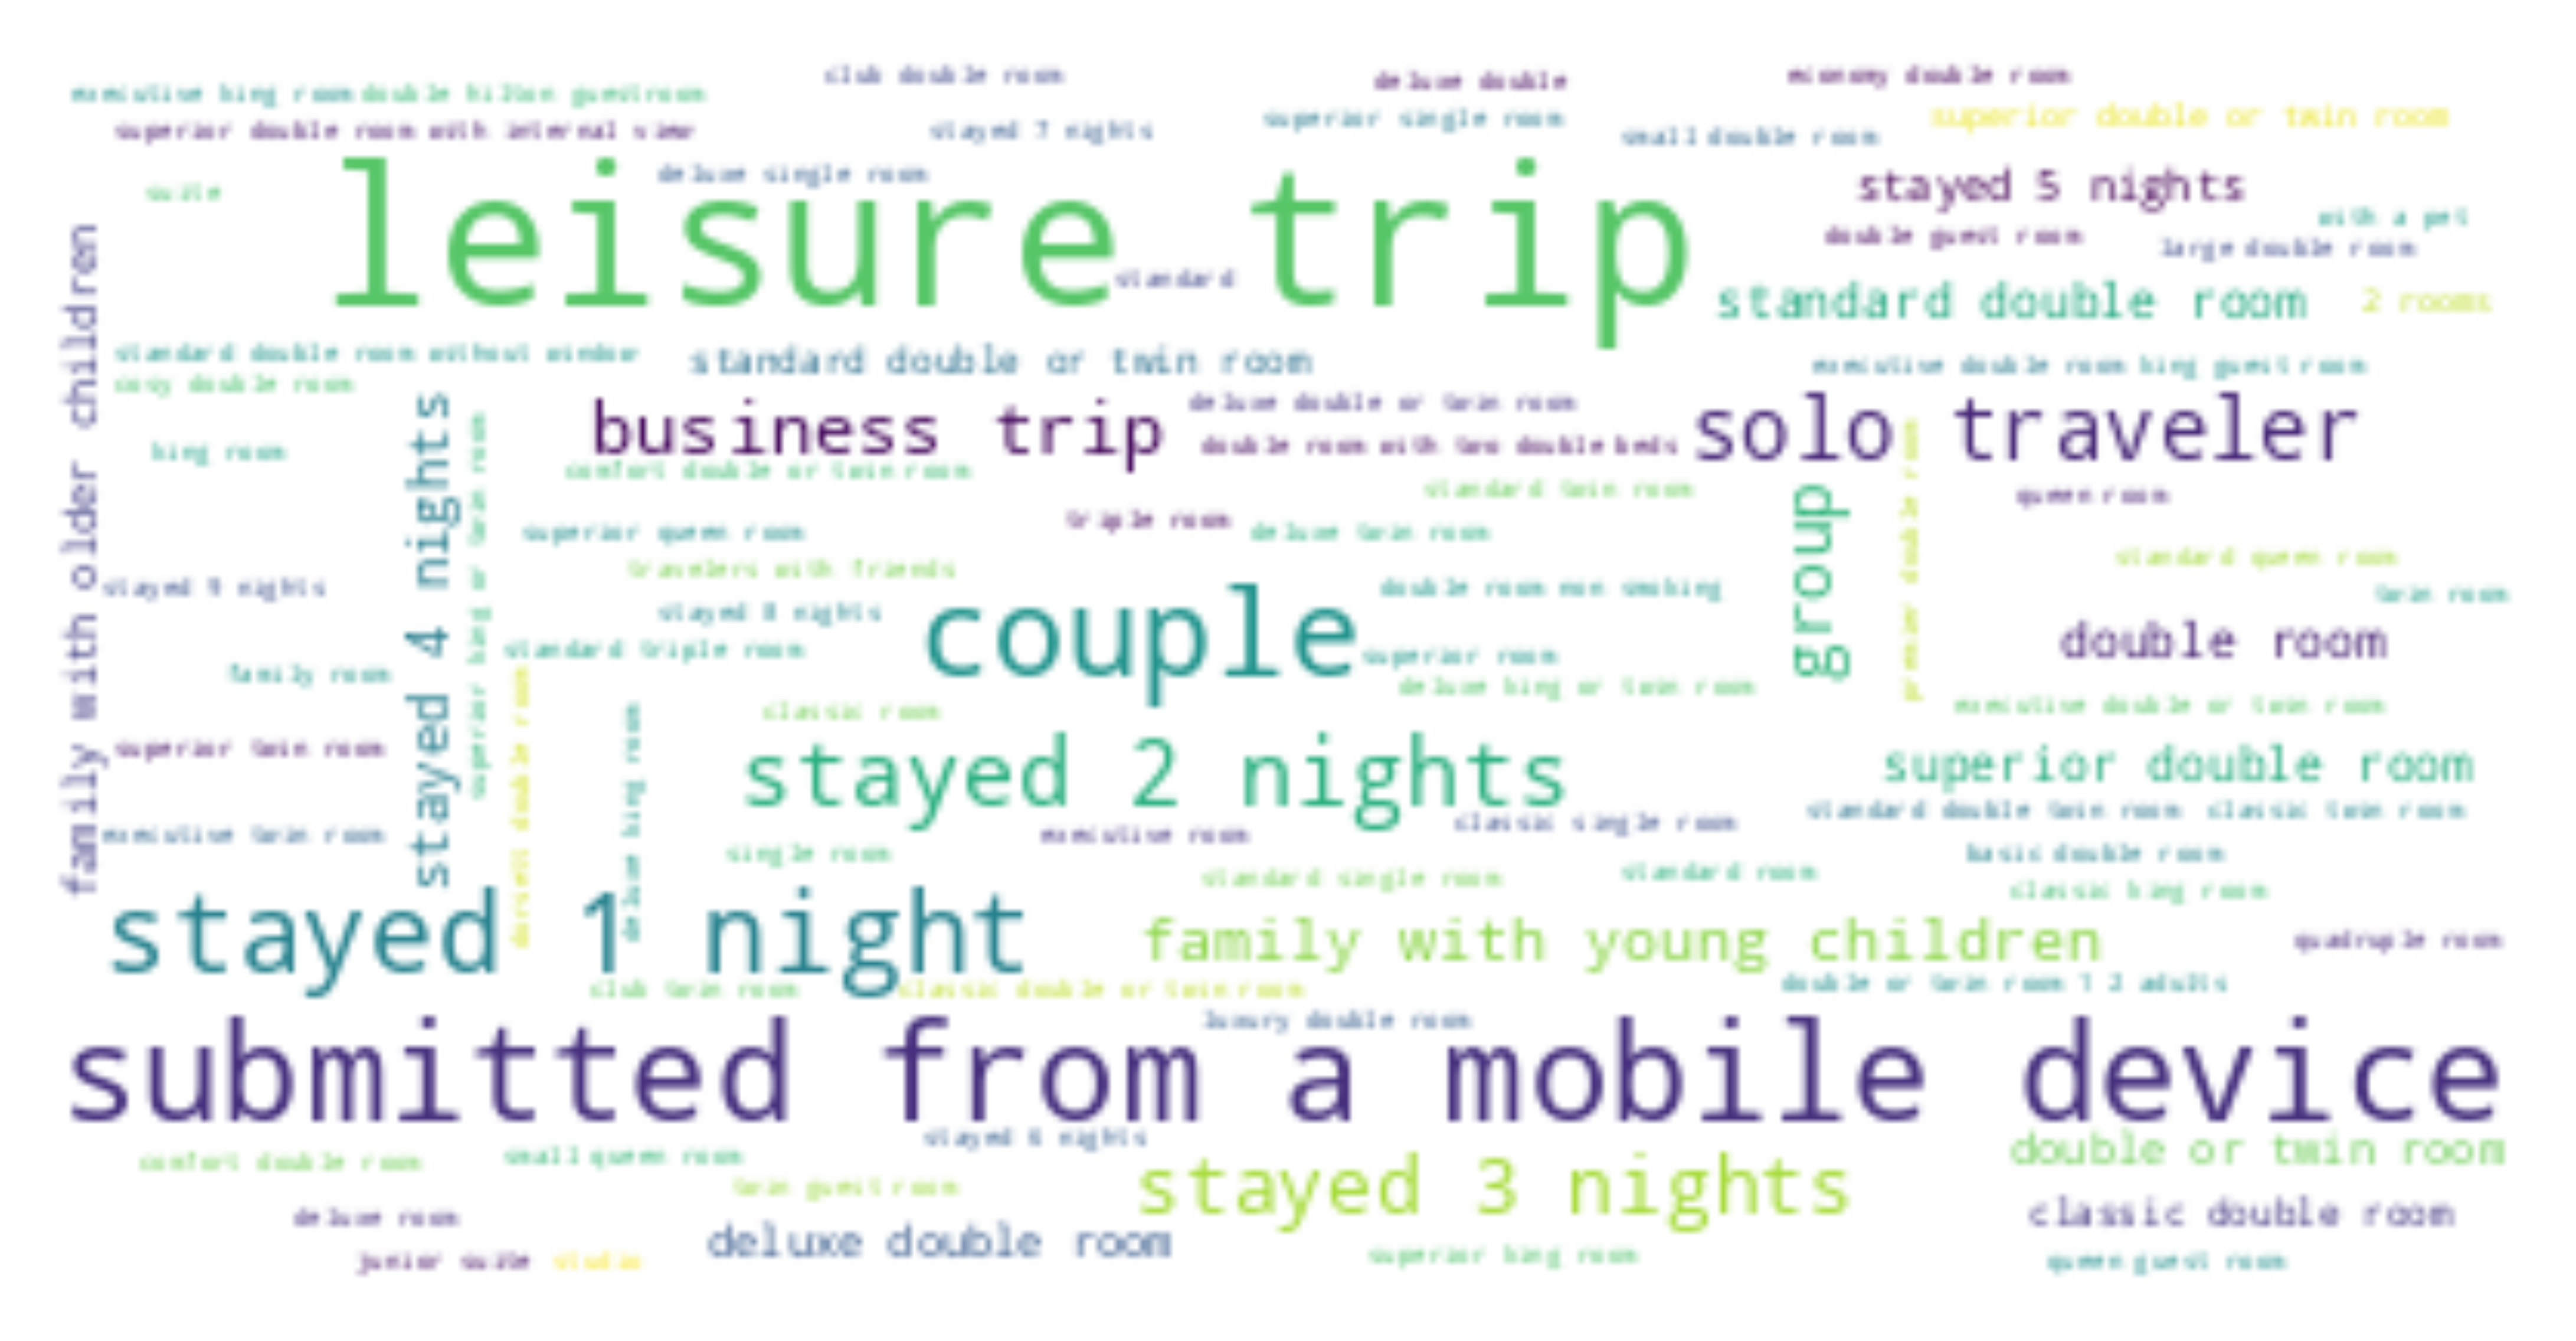

In [126]:
# Visualisation of top tags
wordcloud = WordCloud(background_color='white')
fig = plt.figure(figsize=(6,4), dpi=900)
wordcloud.generate_from_frequencies(all_tags.value_counts())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

I found interesting information in tags:
+ Kind of trip business trip/leisure trip 
+ Numbers of night was stayed
+ Submited from mobile device(it can be usefull)
+ Solo, group, couple, etc.

In [127]:
hotels_df['solo_traveler'] = hotels_df['tags'].apply(lambda x: 1 if 'solo traveler' in x else 0)
hotels_df['couple'] = hotels_df['tags'].apply(lambda x: 1 if 'couple' in x else 0)
hotels_df['group'] = hotels_df['tags'].apply(lambda x: 1 if 'group' in x else 0)
hotels_df['family_with_young_children'] = hotels_df['tags'].apply(lambda x: 1 if 'family with young children' in x else 0)
hotels_df['family_with_older_children'] = hotels_df['tags'].apply(lambda x: 1 if 'family with older children' in x else 0)
hotels_df['submitted_from_a_mobile_device'] = hotels_df['tags'].apply(lambda x: 1 if 'submitted from a mobile device' in x else 0)

In [128]:
# Creating trip type column by applying th function
def get_trip_type(tags):
    """This function get tags list as input data and return trip type

    Args:
        tags (list): _description_

    Returns:
        string: trip type
    """
    if 'leisure trip' in tags:
        return 'leisure'
    if 'business trip' in tags:
        return 'business'
    
hotels_df['trip_type'] = hotels_df['tags'].apply(get_trip_type)

In [129]:
# Checking trip_type for nans
print(f"Nans in trip type: {hotels_df['trip_type'].isna().sum()}")

Nans in trip type: 11221


If we assume that some hotels are more popular among business travelers and others among leisure travelers, then we can fill in the nans with a mode value for this hotels and travel group type. 

In [130]:
def get_travel_group(tags):
    if 'solo traveler' in tags:
        return 'solo'
    if 'couple' in tags:
        return 'couple'
    if 'group' in tags:
        return 'group'
    if 'family with young children' in tags:
        return 'young_children'
    if 'family with older children'in tags:
        return 'older_children'
    
hotels_df['travel_group'] = hotels_df['tags'].apply(get_travel_group)

In [131]:
travel_groups_types = hotels_df['travel_group'].unique()
# Filling NaN's in trip type, as mode for hotel name and travel_group
for hotel in hotels_df[hotels_df['trip_type'].isna()]['hotel_name'].unique():
    for group_type in travel_groups_types:
        mask = (hotels_df['hotel_name'] == hotel) & (hotels_df['travel_group'] == group_type)
        mode_value = hotels_df[mask]['trip_type'].mode()
        if not mode_value.empty:
            hotels_df.loc[mask, 'trip_type'] = hotels_df.loc[mask, 'trip_type'].fillna(mode_value[0])

In [132]:
# Checking for NaN's in trip type again
hotels_df['trip_type'].isna().sum()

56

In [133]:
# Filling other NaN's in trip_type as mode for the hotel
for hotel in hotels_df[hotels_df['trip_type'].isna()]['hotel_name'].unique():
    mode_value = hotels_df[hotels_df['hotel_name'] == hotel]['trip_type'].mode()[0]
    hotels_df.loc[hotels_df['hotel_name'] == hotel, 'trip_type'] = hotels_df.loc[hotels_df['hotel_name'] == hotel, 'trip_type'].fillna(mode_value)

In [134]:
# Checking for NaN's in trip type again
hotels_df['trip_type'].isna().sum()

0

In [135]:
# Creating binary column for trip type
hotels_df['trip_type_bin'] = hotels_df['trip_type'].apply(lambda x: 1 if x == 'leisure' else 0)

In [136]:
all_tags.value_counts()[all_tags.value_counts()>10000]

leisure trip                      313593
submitted from a mobile device    230778
couple                            189212
stayed 1 night                    145373
stayed 2 nights                   100263
solo traveler                      81235
stayed 3 nights                    72000
business trip                      61989
group                              49088
family with young children         45836
stayed 4 nights                    35748
double room                        26386
standard double room               24151
superior double room               23550
family with older children         19802
deluxe double room                 18623
double or twin room                16824
stayed 5 nights                    15611
standard double or twin room       13062
classic double room                12716
superior double or twin room       10238
Name: count, dtype: int64

In [137]:
all_tags.unique()

array(['leisure trip', 'couple', 'studio suite', ...,
       'quadruple room 2 adults 2 children', 'art deco room terrace',
       'executive double room non smoking'], dtype=object)

In [138]:
def get_room_type(tags):
    for tag in tags:
        if 'room' in tag:
            return tag
        if 'suite' in tag:
            return tag
        if 'studio' in tag:
            return tag
        if 'standard' in tag:
            return tag
        if 'deluxe' in tag:
            return tag
        
        

In [139]:
hotels_df['room_type'] = hotels_df['tags'].apply(get_room_type)

In [140]:
hotels_df['room_type'] = hotels_df['room_type'].fillna('other')

In [141]:
def get_room_type_1(room):
    if 'standard' in room and 'room' in room:
        return 'standard_room'
    if 'deluxe' in room and 'room' in room:
        return 'deluxe_room'
    if 'superior' in room and 'room' in room:
        return 'superior_room'
    if 'suite' in room and 'room' in room:
        return 'suite'
    if ('double' in room and 'room' in room) or ('twin' in room and 'room' in room):
        return 'double/twin_room'
    else:
        return 'other'

In [142]:
hotels_df['new_room_type'] = hotels_df['room_type'].apply(get_room_type_1)

In [143]:
hotels_df.groupby(by='new_room_type')['reviewer_score'].mean()

new_room_type
deluxe_room         8.449613
double/twin_room    8.403614
other               8.420732
standard_room       8.166137
suite               8.624501
superior_room       8.542706
Name: reviewer_score, dtype: float64

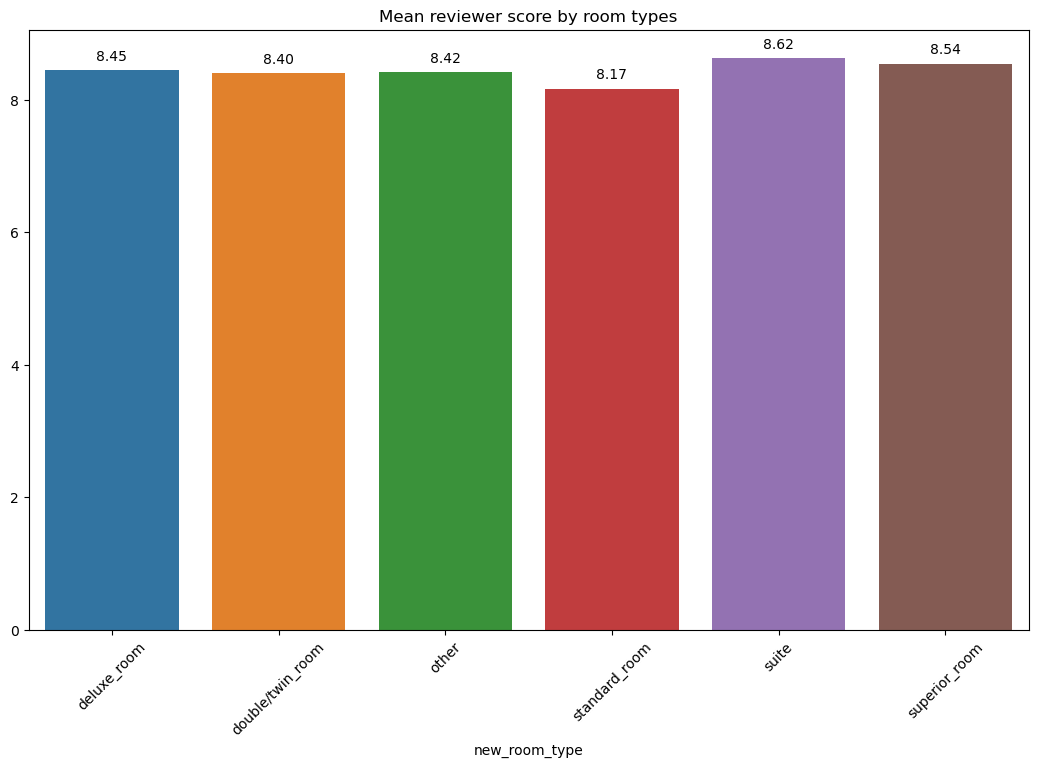

In [144]:
# Creating barplot of mean score by room types
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([1,1,1,1])
temp = hotels_df.groupby(by='new_room_type')['reviewer_score'].mean()
bars = sns.barplot(x=temp.index, y=temp.values, ax=ax)

# Adding numbers to barplot
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
ax.set_title('Mean reviewer score by room types')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)

plt.show()


In [145]:
hotels_df = pd.get_dummies(data=hotels_df, columns=['new_room_type'])

There are differences in the average rating depending on the type of room. As long as I leave this feature.

In [146]:
# Finding information about hotels in chain
hotels_chains = ['Hilton', 'Marriott', 'Holiday Inn', 'Hyatt', 'Sheraton', 
                 'Best Western', 'Crowne Plaza', 'Radisson','Mercure', 'NH', 'Novotel', 
                 'Mercure', 'Accor', 'InterContinental', 'Four Seasons', 'Wyndham',
                 'Ritz', 'Mandarin', 'Fairmont', 'Ibis']

hotels_chains = [chain.lower() for chain in hotels_chains]
hotels_df['hotel_name'] = hotels_df['hotel_name'].str.lower()


def get_hotel_chain(hotel_name):
    for chain in hotels_chains:
        if chain in hotel_name:
            return chain
    return 'no_chain'

        
hotels_df['chain'] = hotels_df['hotel_name'].apply(get_hotel_chain)

In [147]:
temp = hotels_df.groupby(by='chain')['reviewer_score'].mean()

In [148]:
temp

chain
best western        7.978008
crowne plaza        8.533497
fairmont            8.200671
four seasons        9.344845
hilton              8.275384
holiday inn         8.062440
hyatt               7.907926
ibis                7.193750
intercontinental    9.252397
mandarin            8.861250
marriott            8.325789
mercure             8.045027
nh                  8.241231
no_chain            8.450402
novotel             8.296864
radisson            8.389315
ritz                8.567258
sheraton            8.066284
Name: reviewer_score, dtype: float64

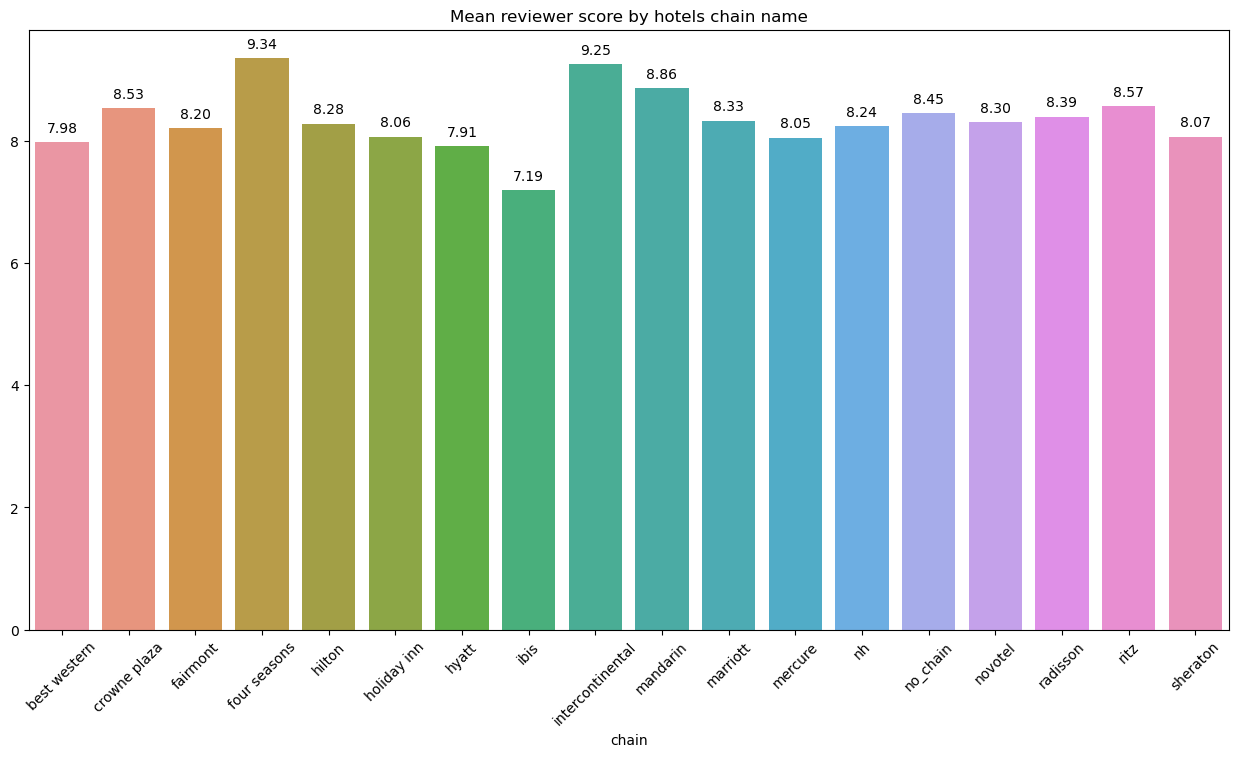

In [149]:

# Creating barplot of mean score by hotel chain
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([1,1,1,1])
bars = sns.barplot(x=temp.index, y=temp.values, ax=ax)

# Adding numbers to barplot
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
ax.set_title('Mean reviewer score by hotels chain name')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)

plt.show()

In [150]:
# One hot encoding of chain column
hotels_df = pd.get_dummies(data=hotels_df, columns=['chain'])

In [151]:
hotels_df['reviewer_nationality'].value_counts().head(10)

reviewer_nationality
United Kingdom              184033
United States of America     26541
Australia                    16239
Ireland                      11126
United Arab Emirates          7617
Saudi Arabia                  6722
Netherlands                   6608
Switzerland                   6498
Canada                        5984
Germany                       5956
Name: count, dtype: int64

In [152]:
top_10_nationality = hotels_df['reviewer_nationality'].value_counts().head(10)


def get_new_nationality(nationality):
    """This function get reviewer_nationality and return
    reviewer_nationality if in top_10 or 'other' if not

    Args:
        nationality (string): reviewer_nationality column data

    Returns:
        string: nationality ro other
    """
    if nationality in top_10_nationality:
        return nationality
    else: 
        return 'other'
    
# Function applying
hotels_df['reviewer_nationality'] = hotels_df['reviewer_nationality'].apply(get_new_nationality)

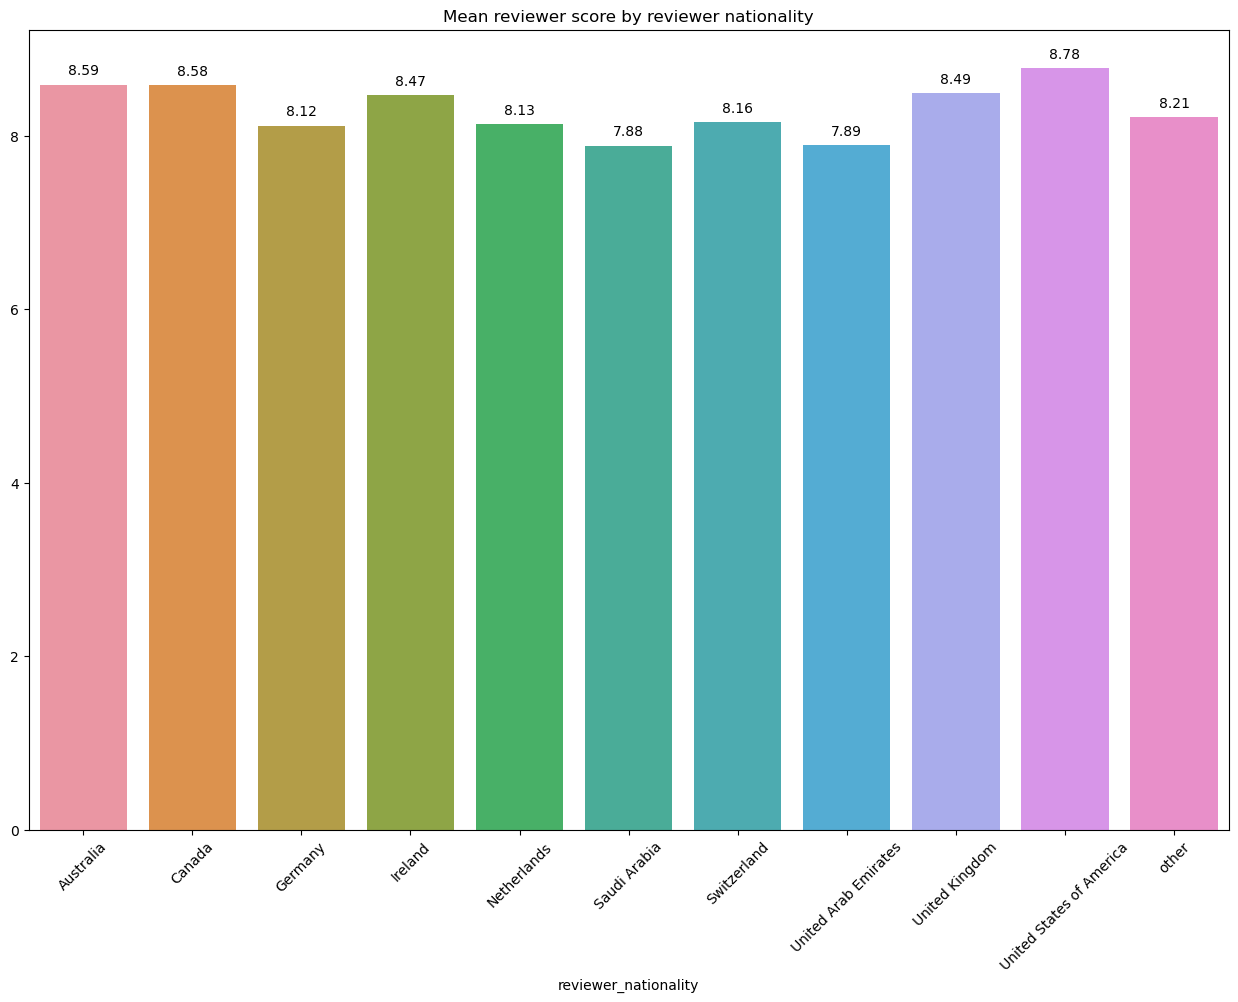

In [153]:
temp = hotels_df.groupby(by='reviewer_nationality')['reviewer_score'].mean()

# Creating barplot of mean score by reviewer nationality
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([1,1,1,1])
bars = sns.barplot(x=temp.index, y=temp.values, ax=ax)

# Adding numbers to barplot
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
ax.set_title('Mean reviewer score by reviewer nationality')
ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)

plt.show()

In [154]:
hotels_df.head(2)

hotel_address   
0  Stratton Street Mayfair Westminster Borough Lo...  \
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring  average_score   
0                           581            8.4  \
1                           299            8.3   

                        hotel_name reviewer_nationality negative_review   
0               the may fair hotel       United Kingdom         leaving  \
1  mercure london bloomsbury hotel       United Kingdom  poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews   
0                                  1                     1994  \
1                                  2                     1361   

      positive_review  review_total_positive_word_counts   
0  staff were amazing                                  3  \
1            location                                  1   

   total_number_of_reviews_reviewer_has_given  reviewer_score   
0                                           7            10.0  \
1                                          14             6.3   

                                                tags  days_since_review   
0  [leisure trip, couple, studio suite, stayed 2 ...                531  \
1  [business trip, couple, standard double room, ...                203   

         lat       lng  date_week  date_day  date_winter  date_spring   
0  51.507894 -0.143671          7         5         True        False  \
1  51.521009 -0.123097          2         4         True        False   

   date_summer  date_autumn    city  inner_traveller  country_Austria   
0        False        False  London             True            False  \
1        False        False  London             True            False   

   country_France  country_Italy  country_Netherlands  country_Spain   
0           False          False                False          False  \
1           False          False                False          False   

   country_United Kingdom                    city_coord   
0                    True  (51.504331316, -0.123166174)  \
1                    True  (51.504331316, -0.123166174)   

                coordinates  distance_to_center postal_code  tourist_dist   
0  (51.5078943, -0.1436707)            1.477814         W1J             1  \
1  (51.5210085, -0.1230966)            1.855478        WC1B             1   

   business_dist  residence_dist  green_dist  historical_dist  shopping_dist   
0              0               0           0                0              1  \
1              0               0           0                1              1   

   entertaining_dist  transport_hub_dist  suburb_dist           positive_list   
0                  1                   1            0  [staff, were, amazing]  \
1                  1                   1            0              [location]   

       negative_list   positive_review_1 negative_review_1  nltk_p_neg   
0          [leaving]  staff were amazing           leaving         0.0  \
1  [poor, breakfast]            location    poor breakfast         0.0   

   nltk_p_neu  nltk_p_pos  nltk_p_compound  nltk_n_neg  nltk_n_neu   
0       0.345       0.655           0.5859       0.000       1.000  \
1       1.000       0.000           0.0000       0.756       0.244   

   nltk_n_pos  nltk_n_compound  afinn_p_score  afinn_n_score  tb_p_polarity   
0         0.0           0.0000            4.0            0.0            0.6  \
1         0.0          -0.4767            0.0           -2.0            0.0   

   tb_p_subjectivity  tb_n_polarity  tb_n_subjectivity  bow_p_amazing   
0                0.9            0.0                0.0              1  \
1                0.0           -0.4                0.6              0   

   bow_p_bar  bow_p_bathroom  bow_p_bed  bow_p_breakfast  bow_p_clean   
0          0               0          0                0            0  \
1          0               0          0                0            0   

   bow_p_close  bow_p_comforta

In [155]:
columns_for_drop = ['hotel_address', 'hotel_name', 'reviewer_nationality', 'reviewer_nationality', 'positive_review', 'tags',
                    'lat', 'lng', 'city_coord', 'coordinates', 'postal_code', 'positive_list', 'negative_list', 'positive_review_1',
                    'negative_review_1', 'trip_type', 'travel_group', 'negative_review', 'room_type', 'city']

num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 
                   'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'date_week',
                   'date_day', 'distance_to_center', 'nltk_p_neg', 'nltk_p_neu', 'nltk_p_pos', 'nltk_p_compound', 'nltk_n_neg',
                   'nltk_n_neu', 'nltk_n_pos', 'nltk_n_compound', 'afinn_p_score', 'afinn_n_score', 'tb_p_polarity', 'tb_p_subjectivity',
                   'tb_n_polarity', 'tb_n_subjectivity']

In [156]:
hotels_df_1 = hotels_df.drop(columns=columns_for_drop)

In [157]:
hotels_df_1

additional_number_of_scoring  average_score   
0                                581            8.4  \
1                                299            8.3   
2                                 32            8.9   
3                                 34            7.5   
4                                914            8.5   
...                              ...            ...   
386798                           107            9.0   
386799                           272            8.4   
386800                           457            6.8   
386801                           365            8.1   
386802                           222            9.0   

        review_total_negative_word_counts  total_number_of_reviews   
0                                       1                     1994  \
1                                       2                     1361   
2                                       4                      406   
3                                       2                      607   
4                                       2                     7586   
...                                   ...                      ...   
386798                                  2                      617   
386799                                  2                     3224   
386800                                 10                     2751   
386801                                  2                     1567   
386802                                 18                     1209   

        review_total_positive_word_counts   
0                                       3  \
1                                       1   
2                                       2   
3                                       9   
4                                      18   
...                                   ...   
386798                                  8   
386799                                 88   
386800                                  8   
386801                                  5   
386802                                 18   

        total_number_of_reviews_reviewer_has_given  reviewer_score   
0                                                7            10.0  \
1                                               14             6.3   
2                                               14             7.5   
3                                                8            10.0   
4                                               10             9.6   
...                                            ...             ...   
386798                                          10             8.8   
386799                                           1             9.2   
386800                                          21             8.3   
386801                                          28             9.2   
386802                                           2             8.8   

        days_since_review  date_week  date_day  date_winter  date_spring   
0                     531          7         5         True        False  \
1                     203          2         4         True        False   
2                     289         42         2        False        False   
3                     681         39         2        False        False   
4                     516          9         6        False         True   
...                   ...        ...       ...          ...          ...   
386798                106         16         3        False         True   
386799                171          7         1         True        False   
386800                543          5         7         True        False   
386801                 74         20         7        False         True   
386802                363         31         5        False        False   

        date_summer  date_autumn  inner_traveller  country_Austria   
0             False        False             True            False  \
1             False        False             True            False   
2

In [169]:
from sklearn import preprocessing

r_scaler = preprocessing.RobustScaler()

hotels_df_1['additional_number_of_scoring'] = r_scaler.fit_transform(hotels_df_1[['additional_number_of_scoring']])
hotels_df_1['total_number_of_reviews'] = r_scaler.fit_transform(hotels_df_1[['total_number_of_reviews']])
hotels_df_1['review_total_positive_word_counts'] = r_scaler.fit_transform(hotels_df_1[['review_total_positive_word_counts']])
hotels_df_1['review_total_negative_word_counts'] = r_scaler.fit_transform(hotels_df_1[['review_total_negative_word_counts']])
hotels_df_1['days_since_review'] = r_scaler.fit_transform(hotels_df_1[['days_since_review']])
hotels_df_1['total_number_of_reviews_reviewer_has_given'] = r_scaler.fit_transform(hotels_df_1[['total_number_of_reviews_reviewer_has_given']])



In [170]:
hotels_df_1

additional_number_of_scoring  average_score   
0                           0.486762            8.4  \
1                          -0.087576            8.3   
2                          -0.631365            8.9   
3                          -0.627291            7.5   
4                           1.164969            8.5   
...                              ...            ...   
386798                     -0.478615            9.0   
386799                     -0.142566            8.4   
386800                      0.234216            6.8   
386801                      0.046843            8.1   
386802                     -0.244399            9.0   

        review_total_negative_word_counts  total_number_of_reviews   
0                               -0.315789                -0.057096  \
1                               -0.263158                -0.315253   
2                               -0.157895                -0.704731   
3                               -0.263158                -0.622757   
4                               -0.263158                 2.223491   
...                                   ...                      ...   
386798                          -0.263158                -0.618679   
386799                          -0.263158                 0.444535   
386800                           0.157895                 0.251631   
386801                          -0.263158                -0.231240   
386802                           0.578947                -0.377243   

        review_total_positive_word_counts   
0                                 -0.4375  \
1                                 -0.5625   
2                                 -0.5000   
3                                 -0.0625   
4                                  0.5000   
...                                   ...   
386798                            -0.1250   
386799                             4.8750   
386800                            -0.1250   
386801                            -0.3125   
386802                             0.5000   

        total_number_of_reviews_reviewer_has_given  reviewer_score   
0                                         0.571429            10.0  \
1                                         1.571429             6.3   
2                                         1.571429             7.5   
3                                         0.714286            10.0   
4                                         1.000000             9.6   
...                                            ...             ...   
386798                                    1.000000             8.8   
386799                                   -0.285714             9.2   
386800                                    2.571429             8.3   
386801                                    3.571429             9.2   
386802                                   -0.142857             8.8   

        days_since_review  date_week  date_day  date_winter  date_spring   
0                0.505682          7         5         True        False  \
1               -0.426136          2         4         True        False   
2               -0.181818         42         2        False        False   
3                0.931818         39         2        False        False   
4                0.463068          9         6        False         True   
...                   ...        ...       ...          ...          ...   
386798          -0.701705         16         3        False         True   
386799          -0.517045          7         1         True        False   
386800           0.539773          5         7         True        False   
386801          -0.792614         20         7        False         True   
386802           0.028409         31         5        False        False   

        date_summer  date_autumn  inner_traveller  country_Austria   
0             False        False             True            False  \
1             False        False             True            False   
2

In [160]:
all_cols = list(hotels_df_1.columns)

In [161]:
cat_cols = []
for col in all_cols:
    if col not in num_cols and col != 'reviewer_score':
        cat_cols.append(col)
        

In [162]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels_df_1.drop(['reviewer_score'], axis = 1)  
y = hotels_df_1['reviewer_score']

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<AxesSubplot:>

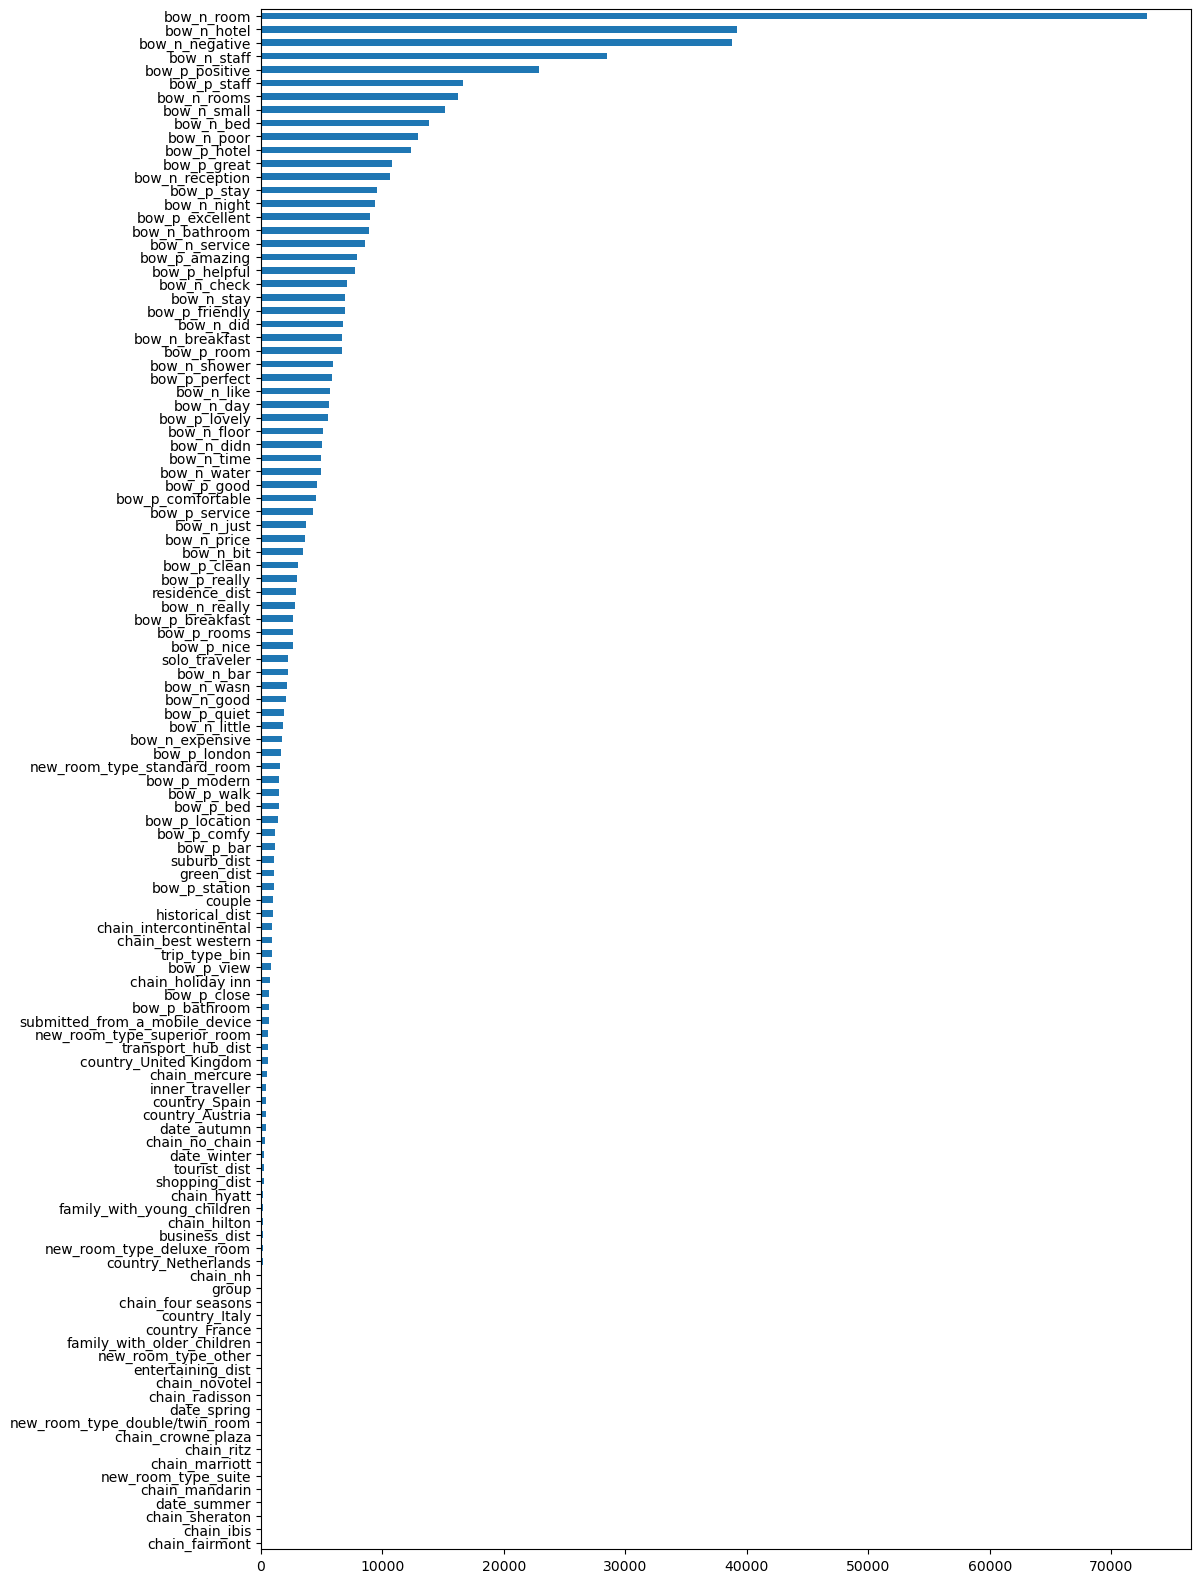

In [163]:
# Chi2 test of features
y=y.astype('int')


from sklearn.feature_selection import chi2
fig = plt.figure(figsize=(12, 20))
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

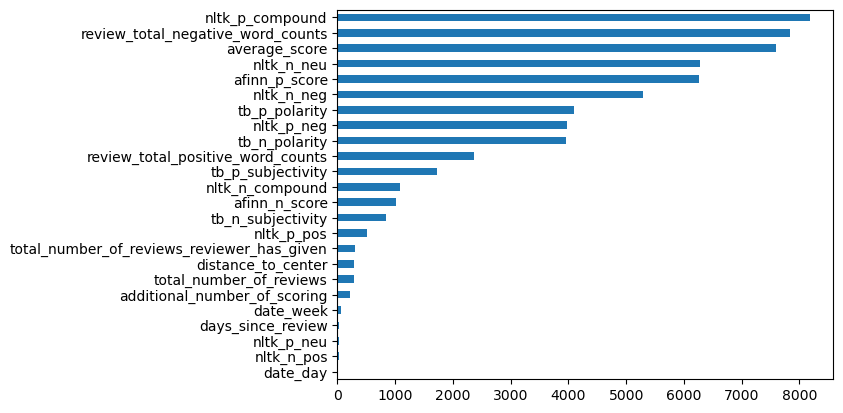

In [164]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [165]:
hotels_df_1

additional_number_of_scoring  average_score   
0                                581            8.4  \
1                                299            8.3   
2                                 32            8.9   
3                                 34            7.5   
4                                914            8.5   
...                              ...            ...   
386798                           107            9.0   
386799                           272            8.4   
386800                           457            6.8   
386801                           365            8.1   
386802                           222            9.0   

        review_total_negative_word_counts  total_number_of_reviews   
0                                       1                     1994  \
1                                       2                     1361   
2                                       4                      406   
3                                       2                      607   
4                                       2                     7586   
...                                   ...                      ...   
386798                                  2                      617   
386799                                  2                     3224   
386800                                 10                     2751   
386801                                  2                     1567   
386802                                 18                     1209   

        review_total_positive_word_counts   
0                                       3  \
1                                       1   
2                                       2   
3                                       9   
4                                      18   
...                                   ...   
386798                                  8   
386799                                 88   
386800                                  8   
386801                                  5   
386802                                 18   

        total_number_of_reviews_reviewer_has_given  reviewer_score   
0                                                7            10.0  \
1                                               14             6.3   
2                                               14             7.5   
3                                                8            10.0   
4                                               10             9.6   
...                                            ...             ...   
386798                                          10             8.8   
386799                                           1             9.2   
386800                                          21             8.3   
386801                                          28             9.2   
386802                                           2             8.8   

        days_since_review  date_week  date_day  date_winter  date_spring   
0                     531          7         5         True        False  \
1                     203          2         4         True        False   
2                     289         42         2        False        False   
3                     681         39         2        False        False   
4                     516          9         6        False         True   
...                   ...        ...       ...          ...          ...   
386798                106         16         3        False         True   
386799                171          7         1         True        False   
386800                543          5         7         True        False   
386801                 74         20         7        False         True   
386802                363         31         5        False        False   

        date_summer  date_autumn  inner_traveller  country_Austria   
0             False        False             True            False  \
1             False        False             True            False   
2

In [166]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [167]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12020215437575847


In [85]:
pd.set_option('display.max_columns', None)
# display(hotels_df.columns)

In [ ]:
# plt.figure(figsize=(15, 12))

# df_reset = hotels_df.groupby(by=['city','solo_traveler'])['reviewer_score'].mean().reset_index()
# ax = plt.subplot(2,3,1)
# sns.barplot(data=df_reset, ax =ax, x='city', y='reviewer_score', hue='solo_traveler')
# ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
# ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
# plt.title('Solo traveler')

# df_reset = hotels_df.groupby(by=['city','couple'])['reviewer_score'].mean().reset_index()
# ax = plt.subplot(2,3,2)
# sns.barplot(data=df_reset, ax =ax, x='city', y='reviewer_score', hue='couple')
# ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
# ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
# plt.title('Couple')

# df_reset = hotels_df.groupby(by=['city','group'])['reviewer_score'].mean().reset_index()
# ax = plt.subplot(2,3,3)
# sns.barplot(data=df_reset, ax =ax, x='city', y='reviewer_score', hue='group')
# ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
# ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
# plt.title('Group')

# df_reset = hotels_df.groupby(by=['city','family_with_young_children'])['reviewer_score'].mean().reset_index()
# ax = plt.subplot(2,3,4)
# sns.barplot(data=df_reset, ax =ax, x='city', y='reviewer_score', hue='family_with_young_children')
# ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
# ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
# plt.title('Family with young children')

# df_reset = hotels_df.groupby(by=['city','family_with_older_children'])['reviewer_score'].mean().reset_index()
# ax = plt.subplot(2,3,5)
# sns.barplot(data=df_reset, ax =ax, x='city', y='reviewer_score', hue='family_with_older_children')
# ax.set_xticklabels(ax.get_xticklabels() ,rotation=45)
# ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
# plt.title('Family with older children')